In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import ase
import time
import numpy as np
import ase.io as aio
import scipy.io as sio
import matplotlib.pyplot as plt
import poremks.porosity as pore
import poremks.grid_generator as gen
from poremks.helpers import write2vtk
from toolz.curried import pipe, curry

you can install torch for speed-up as - 
conda install pytorch-cpu torchvision-cpu -c pytorch


## Load Structure of Interest

### For an amorphous hydrocarbon macromolecular structure

In [3]:
cif = "EFK_50A_0.80.xyz"
fname = os.path.join("hydrocarbons", "EFK_50A_0.80.xyz")

rep = [1]*3
radii={"C":1.7, "H": 1.1, "O": 1.52}
len_pixel=10

### For a 3D bulk zeolite

In [4]:
cif = "MFI.cif"
fname = os.path.join("iza_zeolites", cif)

rep = [1]*3
len_pixel = 10
radii={"Si":1.35, "O": 1.35}

## For 2D slabs

In [3]:
import glob
cifs = glob.glob("likely_min_energy_structures/*.cif")

In [11]:
cif = cifs[0]
print(cif)
fname = os.path.join("", cif)

rep = [2,2,1]
len_pixel = 10
radii={"Si":1.35, "O": 1.35, "H":1.0}

likely_min_energy_structures/zz_EABff-[1,0,1]-L-0.497453_0-U-0.573212_0-ss-19.8283078267.cif


### Load the structure information using ase library as an atom object

In [12]:
atom = pipe(fname, 
            lambda fname: aio.read(fname), 
            lambda x: x.repeat(rep))

print("No. of atoms in the structure: %d" % len(atom))

No. of atoms in the structure: 984


## Generate Voxelized Representation of the Pore Structure

In [13]:
%%time
S = gen.grid_maker(atom, len_pixel=10, radii=radii, full=False, fft=True)[0]
print(S.shape)

(258, 377, 212)
CPU times: user 32.4 s, sys: 5.89 s, total: 38.3 s
Wall time: 38.3 s


### Compute Conventional Pore Metrics - PLD and LCD

In [14]:
strt = time.time()
padval = ((1, 1), (1, 1), (0, 0)) 
S_dgrid = pipe(S,
               lambda s: np.pad(s, padval, 'constant', constant_values=0),
               lambda s: pore.dgrid(s, len_pixel=len_pixel))
end = time.time()
print("distance grid computation time: %1.3fs"%(end-strt))

strt = time.time()
pld  = pore.get_pld(S_dgrid)
end  = time.time()
print("PLD: %1.3f" % pld)
print("PLD computation time: %1.3fs"%(end-strt))

strt = time.time()
lcd  = pore.get_lcd(S_dgrid)
end  = time.time()
print("LCD: %1.3f" % lcd)
print("LCD computation time: %1.3fs"%(end-strt))

distance grid computation time: 1.985s
PLD: 3.320
PLD computation time: 1.474s
LCD: 7.192
LCD computation time: 0.007s


### For PLD in a different direction

In [8]:
%%time
padval = ((1, 1), (1, 1), (0, 0)) 
pld = pipe(S, 
           lambda s: np.rot90(s, axes=(0,2)),
           lambda s: np.pad(s, padval, 'constant', constant_values=0),
           lambda s: pore.dgrid(s, len_pixel=len_pixel),
           lambda s: pore.get_pld(s))
print(pld)

4.3046875
CPU times: user 1.36 s, sys: 125 ms, total: 1.49 s
Wall time: 985 ms


# Geometric analysis of diffusion pathways

- Convert admissible coordinates to graph structure
 - generate adjacency matrix from graph structure
 - use adjacency matrix to identify shortest paths
 - use a Shortest Path heuristic on the adjacency matrix to prune the medial axis network of dead ends.
 - for the pruned path, use eculidean distance from nearest atoms at each path voxel as a metric of pore size distribution

### Extract pore volume accessible to a probe moleucle

In [9]:
strt = time.time()
S_1 = (pore.gen_cleanPore(S_dgrid, r_probe=1.0, r_min=2.5, len_pixel=len_pixel) > 0) * 1
end = time.time()
print("Pore Cleaning Computation Time: %1.3fs" % (end-strt))

Pore Cleaning Computation Time: 0.183s


### Generate skeletonized representation of pore structure

In [10]:
strt = time.time()
S_2 = pipe(S_1, 
           lambda x: np.pad(x, pad_width=((0,0),(0,0),(len_pixel, len_pixel)), mode = "constant", constant_values=1), 
           lambda x: pore.gen_medialAxis(x)[:,:,len_pixel:-len_pixel])
end = time.time()
print("Medial Path Computation Time: %1.3fs" % (end-strt))

Medial Path Computation Time: 1.957s


### Compute Shortest Paths connecting opposing faces of the molecular structure

In [11]:
strt = time.time()
S_3, paths = pore.gen_throughPath(S_2, depth=1)
end = time.time()
print("Through Path Computation Time: %1.3fs" % (end-strt))
print("Mean and setdev of path lengths: %1.3f, %1.3f" % (np.mean(paths), np.std(paths)))

Through Path Computation Time: 0.827s
Mean and setdev of path lengths: 2.860, 0.085


In [12]:
n_channels = len(pore.return_labelled(S_1)[-1])
print("No. of unique channels: %d" % n_channels)

No. of unique channels: 1


### Compute accessible surface area and volume

In [13]:
asa = pore.get_asa(S_1, len_pixel=10)
print("Probe Accessible Surface Area: %1.3f" % asa)
av = np.count_nonzero(S_1) * (1 / len_pixel)**3
print("Probe Accessible Volume: %1.3f" % av)

Probe Accessible Surface Area: 1543.670
Probe Accessible Volume: 720.278


### Compute pore size distribution

In [14]:
psd = S_dgrid[S_2==1]
print("Mean and setdev of pore size distribution: %1.3f, %1.3f" % (np.mean(psd), np.std(psd)))

Mean and setdev of pore size distribution: 1.893, 0.583


In [15]:
dim = np.asarray(S.shape) / len_pixel
print("dimensions of the structure: ", dim)

dimensions of the structure:  [20.2 19.8 13.3]


### Visualize path length distribution (length in angstrom)

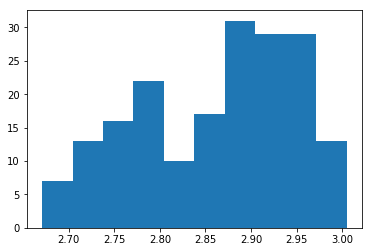

In [16]:
plt.hist(paths)
plt.show()

### Visualize pore size distribution (length in angstrom)

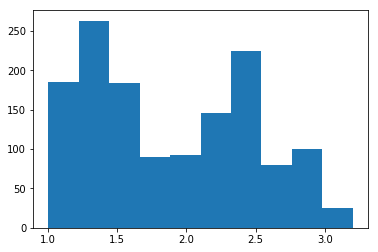

In [17]:
plt.hist(psd)
plt.show()

### Save the grids as vtk files, for 3D visualization in paraview

In [18]:
%%time
write2vtk(S_1, "%s_pore.vtk" % cif)
write2vtk(S_3, "%s_through_path.vtk" % cif)

CPU times: user 4.2 s, sys: 293 ms, total: 4.49 s
Wall time: 4.49 s
